# <span style="color:#0b486b">SIT307 - Assessment 2</span>

## <span style="color:#0b486b">Machine Learning</span>

Interpreting relevant data to predict future outcomes

### Import Libraries

In [1]:
#import regression techiniques
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

#importing classification techniques
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

#importing metric calculators
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import validation_curve
from scipy.stats import zscore

#importing splitting techiniques
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#importing basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import lightgbm as lgbm

### Load CSV

In [2]:
df = pd.read_csv('../Data/vehicles_clean.csv')
df.head()

,id,region,price,year,manufacturer,model,fuel,odometer,transmission,drive,type,paint_color,state
0,7088743681,greensboro,3995,2004.0,honda,element,gas,212526.0,automatic,fwd,SUV,orange,nc
1,7088741418,greensboro,10995,2014.0,chevrolet,traverse,gas,112383.0,automatic,fwd,SUV,black,nc
2,7088737004,greensboro,3995,2007.0,toyota,solara,gas,185123.0,automatic,fwd,convertible,black,nc
3,7088732376,greensboro,7995,2008.0,nissan,frontier,gas,162214.0,automatic,fwd,pickup,red,nc
4,7093461424,denver,7995,2010.0,chevrolet,silverado 1500 4wd,gas,194050.0,automatic,4wd,truck,white,co


### Check Data Cleaning

Text(0.5, 1.0, 'price vs year')

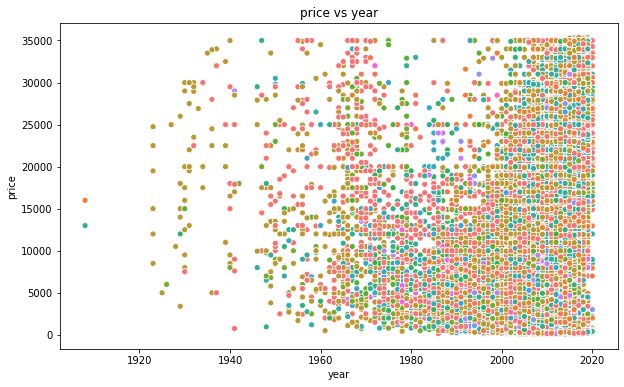

In [3]:
test_y_axis = 'price'
test_x_axis = 'year'
plt.figure(figsize=(10,6))
sns.scatterplot(x=test_x_axis,y=test_y_axis, data=df, hue='manufacturer', legend=False)
plt.title('{} vs {}'.format(test_y_axis,test_x_axis))

From this it is possible to see how the previous cleaning was not up to scratch.  If we look at the z score for each year and manufacturing grouping we can ensure that the data is of a higher standard.

In [4]:
def clean_col(df,item,val):
    df['zscore']=df.groupby(['year', 'manufacturer'])[item].transform(lambda x : zscore(x,ddof=1))
    df = df[df['zscore'] < val]
    df = df[df['zscore'] > -1*val]
    return df

In [5]:
cols_to_clean = {'price','odometer'}

df_clean = df
z_score_max = 1

for col in cols_to_clean:
    df_clean = clean_col(df_clean,col,z_score_max)


C:\Users\lachlan.mcinnes\Anaconda3\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\lachlan.mcinnes\Anaconda3\lib\site-packages\numpy\core\_methods.py:207: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\lachlan.mcinnes\Anaconda3\lib\site-packages\scipy\stats\stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


Text(0.5, 1.0, 'price vs year')

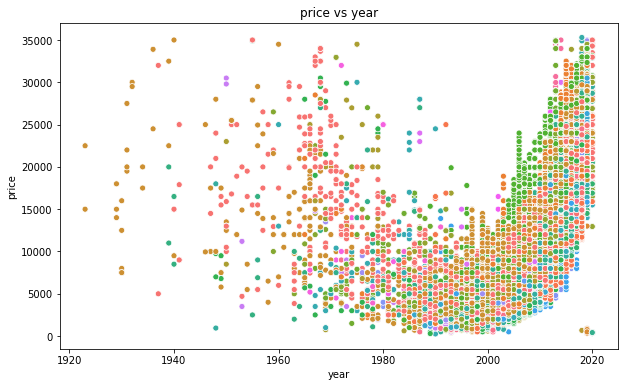

In [6]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=test_x_axis,y=test_y_axis, data=df_clean, hue='manufacturer', legend=False)
plt.title('{} vs {}'.format(test_y_axis,test_x_axis))

Although hard to see, the added cleaning of data has shown a clearer relationship n the data.  This can be taken further by showing a single manufacturer type as shown below.

Text(0.5, 1.0, 'price vs year')

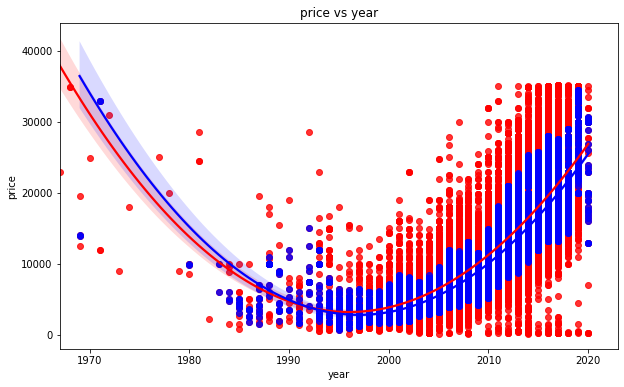

In [7]:
plt.figure(figsize=(10,6))
sns.regplot(x=test_x_axis,y=test_y_axis, data=df[df['manufacturer']=='toyota'], color='red', order=2)
sns.regplot(x=test_x_axis,y=test_y_axis, data=df_clean[df_clean['manufacturer']=='toyota'], color='blue', order=2)
plt.title('{} vs {}'.format(test_y_axis,test_x_axis))

From the plot above it is clear that the relationship found between the data when predicting price is a non-linear correlation.  Thus it is necessary to explore different regression techniques and change the underlying variables in order to see what provide the most accurate results.

### Convert String to Numeric

In [8]:
man = df['manufacturer'].unique()
man.sort()
state = df['state'].unique()
state.sort()
dic={}
for count, val in enumerate(man):
    dic[val]=count
for count, val in enumerate(state):
    dic[val]=count
    
print(dic)

{'acura': 0, 'alfa-romeo': 1, 'audi': 2, 'bmw': 3, 'buick': 4, 'cadillac': 5, 'chevrolet': 6, 'chrysler': 7, 'datsun': 8, 'dodge': 9, 'ferrari': 10, 'fiat': 11, 'ford': 12, 'gmc': 13, 'harley-davidson': 14, 'honda': 15, 'hyundai': 16, 'infiniti': 17, 'jaguar': 18, 'jeep': 19, 'kia': 20, 'land rover': 21, 'lexus': 22, 'lincoln': 23, 'mazda': 24, 'mercedes-benz': 25, 'mercury': 26, 'mini': 27, 'mitsubishi': 28, 'nissan': 29, 'pontiac': 30, 'porche': 31, 'ram': 32, 'rover': 33, 'saturn': 34, 'subaru': 35, 'tesla': 36, 'toyota': 37, 'volkswagen': 38, 'volvo': 39, 'ak': 0, 'al': 1, 'ar': 2, 'az': 3, 'ca': 4, 'co': 5, 'ct': 6, 'dc': 7, 'de': 8, 'fl': 9, 'ga': 10, 'hi': 11, 'ia': 12, 'id': 13, 'il': 14, 'in': 15, 'ks': 16, 'ky': 17, 'la': 18, 'ma': 19, 'md': 20, 'me': 21, 'mi': 22, 'mn': 23, 'mo': 24, 'ms': 25, 'mt': 26, 'nc': 27, 'nd': 28, 'ne': 29, 'nh': 30, 'nj': 31, 'nm': 32, 'nv': 33, 'ny': 34, 'oh': 35, 'ok': 36, 'or': 37, 'pa': 38, 'ri': 39, 'sc': 40, 'sd': 41, 'tn': 42, 'tx': 43, 'ut'

In [9]:
df_clean_numeric = df_clean.replace(dic)
df_numeric = df.replace(dic)

In [10]:
def bin_column(df_bin):
    df_bin['odometer_bin'] = (df_bin['odometer'] // 5000) * 5000
    df_bin['price_bin'] = (df_bin['price'] // 500) * 500
    return df_bin

df_clean_numeric = bin_column(df_clean_numeric)
df_numeric = bin_column(df_numeric)

### Setup Training and Testing Splits

In [11]:
def return_train_splits(df_split):
    feature_cols = ['odometer_bin','year','manufacturer','state']
    X = df_split[feature_cols]
    y = df_split.price_bin

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)
    
    return Xtrain, Xtest, ytrain, ytest

#find the correct splits for the pre and post added cleaning on dataframe
#results between the two show that the cleaned data returns more valid results
Xtrain, Xtest, ytrain, ytest = return_train_splits(df_clean_numeric)

In [12]:
Xtrain[:3]

,odometer_bin,year,manufacturer,state
94332,165000.0,1998.0,38,45
58898,200000.0,2005.0,29,9
140802,30000.0,2017.0,28,37


In [13]:
ytrain[:3]

94332     1500
58898     4500
140802    7500
Name: price_bin, dtype: int64

### Setup Accuracy Readings

In [14]:
def provide_accuracies(y,predictX):
    r2 = round(r2_score(y, predictX),4)
    mse = round(mean_squared_error(y, predictX),2)
    mae = round(median_absolute_error(y, predictX),2)
    
    print_string = "-----Regression Accuracies-----\n"
    print_string += "R Squared:\t\t {} \n".format(r2)
    print_string += "Mean Squared Error:\t {} \n".format(mse)
    print_string += "Median Absolute Error:\t {} \n".format(mae)
    print_string += "-------------------------------"
    
    print(print_string)
    
    return [r2,mse,mae]

### Setup Output Chart

In [15]:
row = ['R Squared','Mean Squared Error','Median Absolute Error','Model','Data Source']
data = {'Accuracy':row}
df_outcome = pd.DataFrame(data)
df_outcome

,Accuracy
0,R Squared
1,Mean Squared Error
2,Median Absolute Error
3,Model
4,Data Source


In [16]:
df_numeric

,id,region,price,year,manufacturer,model,fuel,odometer,transmission,drive,type,paint_color,state,zscore,odometer_bin,price_bin
0,7088743681,greensboro,3995,2004.0,15,element,gas,212526.0,automatic,fwd,SUV,orange,27,0.557358,210000.0,3500
1,7088741418,greensboro,10995,2014.0,6,traverse,gas,112383.0,automatic,fwd,SUV,black,27,0.494608,110000.0,10500
2,7088737004,greensboro,3995,2007.0,37,solara,gas,185123.0,automatic,fwd,convertible,black,27,0.477670,185000.0,3500
3,7088732376,greensboro,7995,2008.0,29,frontier,gas,162214.0,automatic,fwd,pickup,red,27,0.511729,160000.0,7500
4,7093461424,denver,7995,2010.0,6,silverado 1500 4wd,gas,194050.0,automatic,4wd,truck,white,5,0.683122,190000.0,7500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218582,7088767324,greensboro,6695,2012.0,39,s60,gas,121898.0,automatic,fwd,sedan,silver,27,-0.113254,120000.0,6500
218583,7076307686,syracuse,6300,2014.0,29,altima,gas,85000.0,automatic,fwd,sedan,grey,34,0.111529,85000.0,6000
218584,7093462901,denver,5295,2006.0,2,a4 2.0t avant quattro,gas,150000.0,automatic,4wd,wagon,custom,5,0.514120,150000.0,5000
218585,7088752165,greensboro,13995,2016.0,29,frontier,gas,97545.0,automatic,4wd,pickup,silver,27,1.450249,95000.0,13500


### LightGBM

-----Regression Accuracies-----
R Squared:		 0.8141 
Mean Squared Error:	 9214119.45 
Median Absolute Error:	 1832.41 
-------------------------------


Text(0.5, 1.0, 'Feature Importance')

<Figure size 720x432 with 0 Axes>

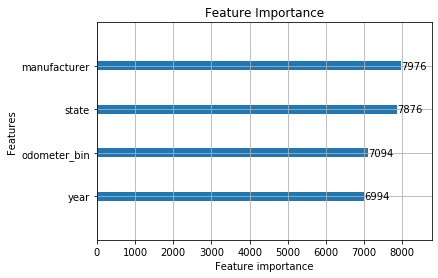

In [17]:
train_set = lgbm.Dataset(Xtrain, ytrain, silent=False)
valid_set = lgbm.Dataset(Xtest, ytest, silent=False)

params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': 10,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,        
    }

modelLGBM = lgbm.train(params, train_set = train_set, num_boost_round=1000,
                    early_stopping_rounds=50,verbose_eval=False, valid_sets=valid_set)

array = provide_accuracies(ytest,modelLGBM.predict(Xtest))
array.append('LGBM')
array.append('Clean')
df_outcome['LGBM'] = array
    
plt.figure(figsize=(10,6))
lgbm.plot_importance(modelLGBM)
plt.title('Feature Importance')

### Random Forest Regressor

In [18]:
#def random_forest_regressor(X_train, X_test, y_train, y_test):
#    rf_regr = RandomForestRegressor(max_depth=10, random_state=0)
#    rf_regr.fit(X_train,y_train)
#    provide_accuracies(y_test,rf_regr.predict(X_test))

rf_regr = RandomForestRegressor(max_depth=10, random_state=0)
rf_regr.fit(Xtrain,ytrain)
array = provide_accuracies(ytest,rf_regr.predict(Xtest))
array.append('RF')
array.append('Clean')
df_outcome['RF'] = array

-----Regression Accuracies-----
R Squared:		 0.8025 
Mean Squared Error:	 9792335.81 
Median Absolute Error:	 1927.12 
-------------------------------


### Decision Tree Regressor

In [19]:
#def decision_tree_regressor(X_train, X_test, y_train, y_test):
#    dt_regr = DecisionTreeRegressor(max_depth=10, random_state=0)
#    dt_regr.fit(X_train, y_train)
#    provide_accuracies(y_test,dt_regr.predict(X_test))

dt_regr = DecisionTreeRegressor(max_depth=10, random_state=0)
dt_regr.fit(Xtrain, ytrain)
array = provide_accuracies(ytest,dt_regr.predict(Xtest))
array.append('DT')
array.append('Clean')
df_outcome['DT'] = array

-----Regression Accuracies-----
R Squared:		 0.7913 
Mean Squared Error:	 10343620.1 
Median Absolute Error:	 1977.84 
-------------------------------


### Linear Regression

In [20]:
#def linear_regressor(X_train, X_test, y_train, y_test):
#    lin_regr = LinearRegression()
#    lin_regr.fit(X_train, y_train)
#    provide_accuracies(y_test, lin_regr.predict(X_test))

lin_regr = LinearRegression()
lin_regr.fit(Xtrain, ytrain)
array = provide_accuracies(ytest, lin_regr.predict(Xtest))
array.append('LR')
array.append('Clean')
df_outcome['LR'] = array

-----Regression Accuracies-----
R Squared:		 0.4843 
Mean Squared Error:	 25566497.59 
Median Absolute Error:	 3360.88 
-------------------------------


### Neural Network Regressor

In [21]:
#def mlp_regressor(X_train, X_test, y_train, y_test):
#    mlp_regr = MLPRegressor(hidden_layer_sizes=(30,30,30))
#    mlp_regr.fit(X_train, y_train)
#    provide_accuracies(y_test, mlp_regr.predict(X_test))

mlp_regr = MLPRegressor(hidden_layer_sizes=(30,30,30))
mlp_regr.fit(Xtrain, ytrain)
array = provide_accuracies(ytest, mlp_regr.predict(Xtest))
array.append('NN')
array.append('Clean')
df_outcome['NN'] = array

-----Regression Accuracies-----
R Squared:		 0.4364 
Mean Squared Error:	 27937318.34 
Median Absolute Error:	 3053.23 
-------------------------------


In [22]:
df_outcome

,Accuracy,LGBM,RF,DT,LR,NN
0,R Squared,0.8141,0.8025,0.7913,0.4843,0.4364
1,Mean Squared Error,9.21412e+06,9.79234e+06,1.03436e+07,2.55665e+07,2.79373e+07
2,Median Absolute Error,1832.41,1927.12,1977.84,3360.88,3053.23
3,Model,LGBM,RF,DT,LR,NN
4,Data Source,Clean,Clean,Clean,Clean,Clean


In [24]:
#col = ['LGBM','RF','DT','LR','NN']

#for c in col:
#    df_outcome[c] = df_outcome[c].apply(lambda x: '{:,}'.format(float(x)) if x.isnumeric())

df_transpose = df_outcome.transpose()
df_transpose.columns=['R Squared','Mean Squared Error','Median Absolute Error','Model','Data Source']
df_transpose = df_transpose.drop('Accuracy')
df_transpose

,R Squared,Mean Squared Error,Median Absolute Error,Model,Data Source
LGBM,0.8141,9.21412e+06,1832.41,LGBM,Clean
RF,0.8025,9.79234e+06,1927.12,RF,Clean
DT,0.7913,1.03436e+07,1977.84,DT,Clean
LR,0.4843,2.55665e+07,3360.88,LR,Clean
NN,0.4364,2.79373e+07,3053.23,NN,Clean


Text(0.5, 1.0, 'price vs year')

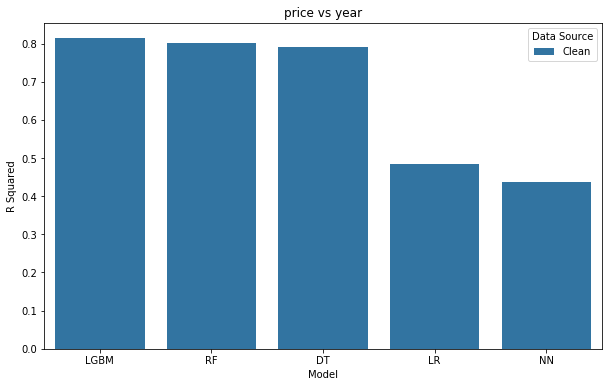

In [25]:
plt.figure(figsize=(10,6))
sns.barplot(x='Model',y='R Squared', data=df_transpose, hue='Data Source')
plt.title('{} vs {}'.format(test_y_axis,test_x_axis))

### Run with Dirty Data

In [26]:
Xtrain, Xtest, ytrain, ytest = return_train_splits(df_numeric)

#lightGBM
print("Results for LightGBM\n")
train_set = lgbm.Dataset(Xtrain, ytrain, silent=False)
valid_set = lgbm.Dataset(Xtest, ytest, silent=False)

params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': 10,
        'subsample': 0.8,
        'bagging_fraction' : 1,
        'max_bin' : 5000 ,
        'bagging_freq': 20,
        'colsample_bytree': 0.6,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1,
        'zero_as_missing': True,
        'seed':0,        
    }

modelLGBM = lgbm.train(params, train_set = train_set, num_boost_round=1000,
                    early_stopping_rounds=50,verbose_eval=False, valid_sets=valid_set)

array = provide_accuracies(ytest,modelLGBM.predict(Xtest))
array.append('LGBM')
array.append('Dirty')
df_outcome['LGBM_D'] = array

#Random Forest Regression
print("Results for Random Forest Regression\n")
rf_regr = RandomForestRegressor(max_depth=10, random_state=0)
rf_regr.fit(Xtrain,ytrain)
array = provide_accuracies(ytest,rf_regr.predict(Xtest))
array.append('RF')
array.append('Dirty')
df_outcome['RF_D'] = array

#Decison Tree Regression
print("Results for Decision Tree Regression\n")
dt_regr = DecisionTreeRegressor(max_depth=10, random_state=0)
dt_regr.fit(Xtrain, ytrain)
array = provide_accuracies(ytest,dt_regr.predict(Xtest))
array.append('DT')
array.append('Dirty')
df_outcome['DT_D'] = array

#Linear Regression
print("Results for Linear Regression\n")
lin_regr = LinearRegression()
lin_regr.fit(Xtrain, ytrain)
array = provide_accuracies(ytest, lin_regr.predict(Xtest))
array.append('LR')
array.append('Dirty')
df_outcome['LR_D'] = array

#Neural Network
print("Results for Neural Network\n")
mlp_regr = MLPRegressor(hidden_layer_sizes=(30,30,30))
mlp_regr.fit(Xtrain, ytrain)
array = provide_accuracies(ytest, mlp_regr.predict(Xtest))
array.append('NN')
array.append('Dirty')
df_outcome['NN_D'] = array

df_outcome

-----Regression Accuracies-----
R Squared:		 0.5675 
Mean Squared Error:	 29679893.04 
Median Absolute Error:	 3021.63 
-------------------------------
-----Regression Accuracies-----
R Squared:		 0.5556 
Mean Squared Error:	 30498608.94 
Median Absolute Error:	 3103.09 
-------------------------------
-----Regression Accuracies-----
R Squared:		 0.5371 
Mean Squared Error:	 31764075.14 
Median Absolute Error:	 3181.82 
-------------------------------
-----Regression Accuracies-----
R Squared:		 0.2339 
Mean Squared Error:	 52572339.53 
Median Absolute Error:	 4944.01 
-------------------------------
-----Regression Accuracies-----
R Squared:		 0.294 
Mean Squared Error:	 48446484.46 
Median Absolute Error:	 4293.93 
-------------------------------


,Accuracy,LGBM,RF,DT,LR,NN,LGBM_D,RF_D,DT_D,LR_D,NN_D
0,R Squared,0.8141,0.8025,0.7913,0.4843,0.4364,0.5675,0.5556,0.5371,0.2339,0.294
1,Mean Squared Error,9.21412e+06,9.79234e+06,1.03436e+07,2.55665e+07,2.79373e+07,2.96799e+07,3.04986e+07,3.17641e+07,5.25723e+07,4.84465e+07
2,Median Absolute Error,1832.41,1927.12,1977.84,3360.88,3053.23,3021.63,3103.09,3181.82,4944.01,4293.93
3,Model,LGBM,RF,DT,LR,NN,LGBM,RF,DT,LR,NN
4,Data Source,Clean,Clean,Clean,Clean,Clean,Dirty,Dirty,Dirty,Dirty,Dirty


In [27]:
df_transpose = df_outcome.transpose()
df_transpose.columns=['R Squared','Mean Squared Error','Median Absolute Error','Model','Data Source']
df_transpose = df_transpose.drop('Accuracy')
df_transpose

,R Squared,Mean Squared Error,Median Absolute Error,Model,Data Source
LGBM,0.8141,9.21412e+06,1832.41,LGBM,Clean
RF,0.8025,9.79234e+06,1927.12,RF,Clean
DT,0.7913,1.03436e+07,1977.84,DT,Clean
LR,0.4843,2.55665e+07,3360.88,LR,Clean
NN,0.4364,2.79373e+07,3053.23,NN,Clean
LGBM_D,0.5675,2.96799e+07,3021.63,LGBM,Dirty
RF_D,0.5556,3.04986e+07,3103.09,RF,Dirty
DT_D,0.5371,3.17641e+07,3181.82,DT,Dirty
LR_D,0.2339,5.25723e+07,4944.01,LR,Dirty
NN_D,0.294,4.84465e+07,4293.93,NN,Dirty


Text(0.5, 1.0, 'price vs year')

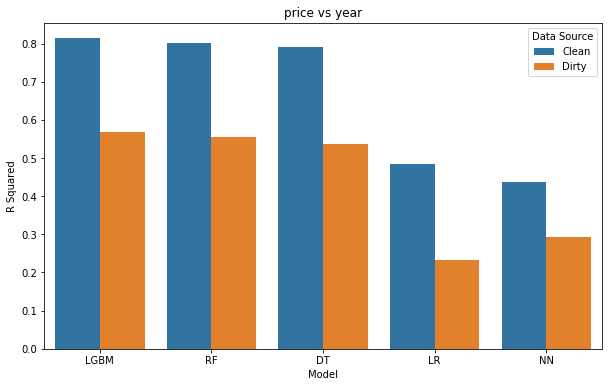

In [28]:
plt.figure(figsize=(10,6))
sns.barplot(x='Model',y='R Squared', data=df_transpose, hue='Data Source')
plt.title('{} vs {}'.format(test_y_axis,test_x_axis))

### Test Different Parameters

In [31]:
def test_param(model, param, range_test):
    train_scores, valid_scores = validation_curve(model, Xtrain, ytrain, param_name=param, param_range=range_test, cv=10, scoring="r2")
    mean_train_score = np.mean(train_scores, axis=1) 
    mean_val_score   = np.mean(valid_scores, axis=1)

    plt.figure(figsize=(10,6))
    plt.plot(range_test, mean_train_score, color="blue", linewidth=1.5, label="Training")
    plt.plot(range_test, mean_val_score, color="red", linewidth=1.5, label="Validation")
    plt.legend(loc="upper left")
    plt.xlabel("Tree-depth")
    plt.ylabel("Model Accuracy")
    plt.title("Accuracy comparison when changing {} for model {}".format(param,model.__class__.__name__))

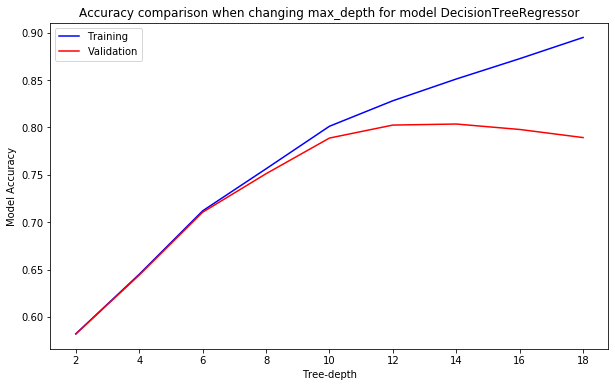

In [32]:
Xtrain, Xtest, ytrain, ytest = return_train_splits(df_clean_numeric)

test_param(dt_regr, "max_depth", range(2, 20, 2))

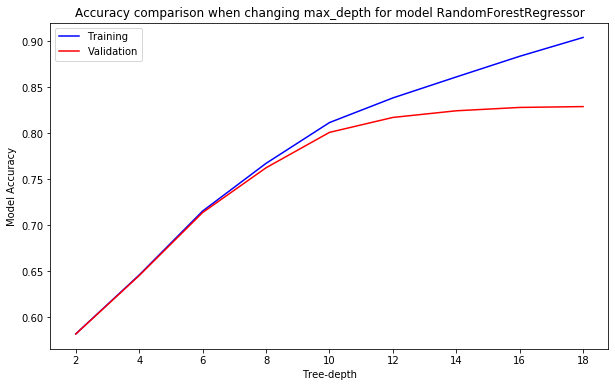

In [33]:
test_param(rf_regr, "max_depth", range(2, 20, 2))

# THE REST OF THIS NEEDS WORK

### Decision Tree Classification

In [ ]:
treeclf = DecisionTreeClassifier(max_depth=5, random_state=0)
treeclf.fit(Xtrain, ytrain)

In [ ]:
treeclf.predict(Xtrain)[:5]

In [ ]:
ytrain[:5]

In [ ]:
score_r2 = r2_score(ytrain, treeclf.predict(Xtrain))
score_tree = treeclf.score(Xtrain, ytrain)
print(score_r2)
print(score_tree)


In [ ]:
print("Training accuracy: {}".format(accuracy_score(ytrain, treeclf.predict(Xtrain))))
print("Testing accuracy: {}".format(accuracy_score(ytest, treeclf.predict(Xtest))))

In [ ]:
scores = cross_val_score(treeclf, Xtrain, ytrain, cv=10, scoring='accuracy')
print("Accuracy for each fold: {}".format(scores))
print("Mean Accuracy: {}".format(np.mean(scores)))

In [ ]:
max_depth_range = range(1, 20)

%time train_scores, valid_scores = validation_curve(treeclf, Xtrain, ytrain, param_name="max_depth", param_range=max_depth_range, cv=10, scoring="accuracy")

In [ ]:
valid_scores[:3]

In [ ]:
np.mean(valid_scores[:3], axis=1)

In [ ]:
mean_train_score = np.mean(train_scores, axis=1) 
mean_val_score   = np.mean(valid_scores, axis=1)

plt.plot(max_depth_range, mean_train_score, color="blue", linewidth=1.5, label="Training")
plt.plot(max_depth_range, mean_val_score, color="red", linewidth=1.5, label="Validation")
plt.legend(loc="upper left")
plt.xlabel("Tree-depth")
plt.ylabel("Model Accuracy")
plt.title("Accuracy comparison of training/validation set")

### Regression

In [ ]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xtest.shape)
print(ytest.shape)

In [ ]:
lr_model = LinearRegression()

lr_model.fit(Xtrain, ytrain)

In [ ]:
ypredicts = lr_model.predict(Xtest)

print("The predicted sales:")
print(ypredicts[:5])
print()
print("The true sales:")
print(ytest[:5])

In [ ]:
mse = np.mean((ypredicts - ytest) ** 2)

print("MSE: {}".format(mse))

In [ ]:
print(lr_model.intercept_)
print(lr_model.coef_)

print(zip(feature_cols, lr_model.coef_))

In [ ]:
def getMSErrorwithSize(model, train_sizes, Xtrain, ytrain, Xtest, ytest):
    
    # Initialize needed variables   
    model_mse   = np.zeros(len(train_sizes))  # storing model accuracy
    model_wts   = np.zeros([len(train_sizes), 4]) # storing model weights
    
    #Train our model with increasing data for each iteration
    for size in train_sizes:    
        Xsubtrain = Xtrain[0:size,:]
        ysubtrain = ytrain[0:size]
        model.fit(Xsubtrain, ysubtrain)
    
        # Test our model on fixed test set
        ypredicts = model.predict(Xtest)    
        
        index              = int(size/100)-1   
        model_mse[index]   = np.mean((ypredicts - ytest)**2)
        model_wts[index,:] = np.append(model.intercept_, model.coef_)  

    return model_mse, model_wts

def getR2ErrorwithSize(model, train_sizes, Xtrain, ytrain, Xtest, ytest):
    
    # Initialize needed variables   
    model_r2   = np.zeros(len(train_sizes))  # storing model accuracy
        
    #Train our model with increasing data for each iteration
    for size in train_sizes:    
        Xsubtrain = Xtrain[0:size,:]
        ysubtrain = ytrain[0:size]
        model.fit(Xsubtrain, ysubtrain)
    
        # Test our model on fixed test set
        ypredicts = model.predict(Xtest)    
        
        index              = int(size/100)-1   
        model_r2[index]   = r2_score(ypredicts,ytest)

    return model_r2

In [ ]:
train_sizes = np.arange(100,1500,100) # training size from 10 to 140
#mse,weights = getMSErrorwithSize(lr_model,train_sizes, Xtrain.to_numpy(), ytrain.to_numpy(), Xtest.to_numpy(), ytest.to_numpy())
r2_exp = getR2ErrorwithSize(lr_model,train_sizes, Xtrain.to_numpy(), ytrain.to_numpy(), Xtest.to_numpy(), ytest.to_numpy())
print(train_sizes)

In [ ]:
plt.plot(train_sizes, r2_exp)
plt.xlabel('Training Size')
plt.ylabel('Mean Sq Error in Prediction')
plt.title('Effect of Data size on prediction error')

### Machine Learning

In [ ]:
scaler = StandardScaler()
scaler.fit(Xtrain)
Xtrain = scaler.transform(Xtrain)
Xtest = scaler.transform(Xtest)

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30))

In [ ]:
mlp.fit(Xtrain,ytrain)

In [ ]:
predictions = mlp.predict(Xtest)

In [ ]:
print("Training accuracy: {}".format(accuracy_score(ytest, mlp.predict(Xtest))))

In [ ]:
provide_accuracies(ytest, mlp.predict(Xtest))

In [ ]:
print(confusion_matrix(ytest,predictions))

In [ ]:
print(classification_report(ytest,predictions))